# Dordek et al., 2016 grid cell representations

In this notebook we carry out simple predictions of what grid cells could look like by simulating place cell input to a feedforward model with trajectories generated by RatInABox.

https://elifesciences.org/articles/10094


Final 'goal' figure to reproduce:

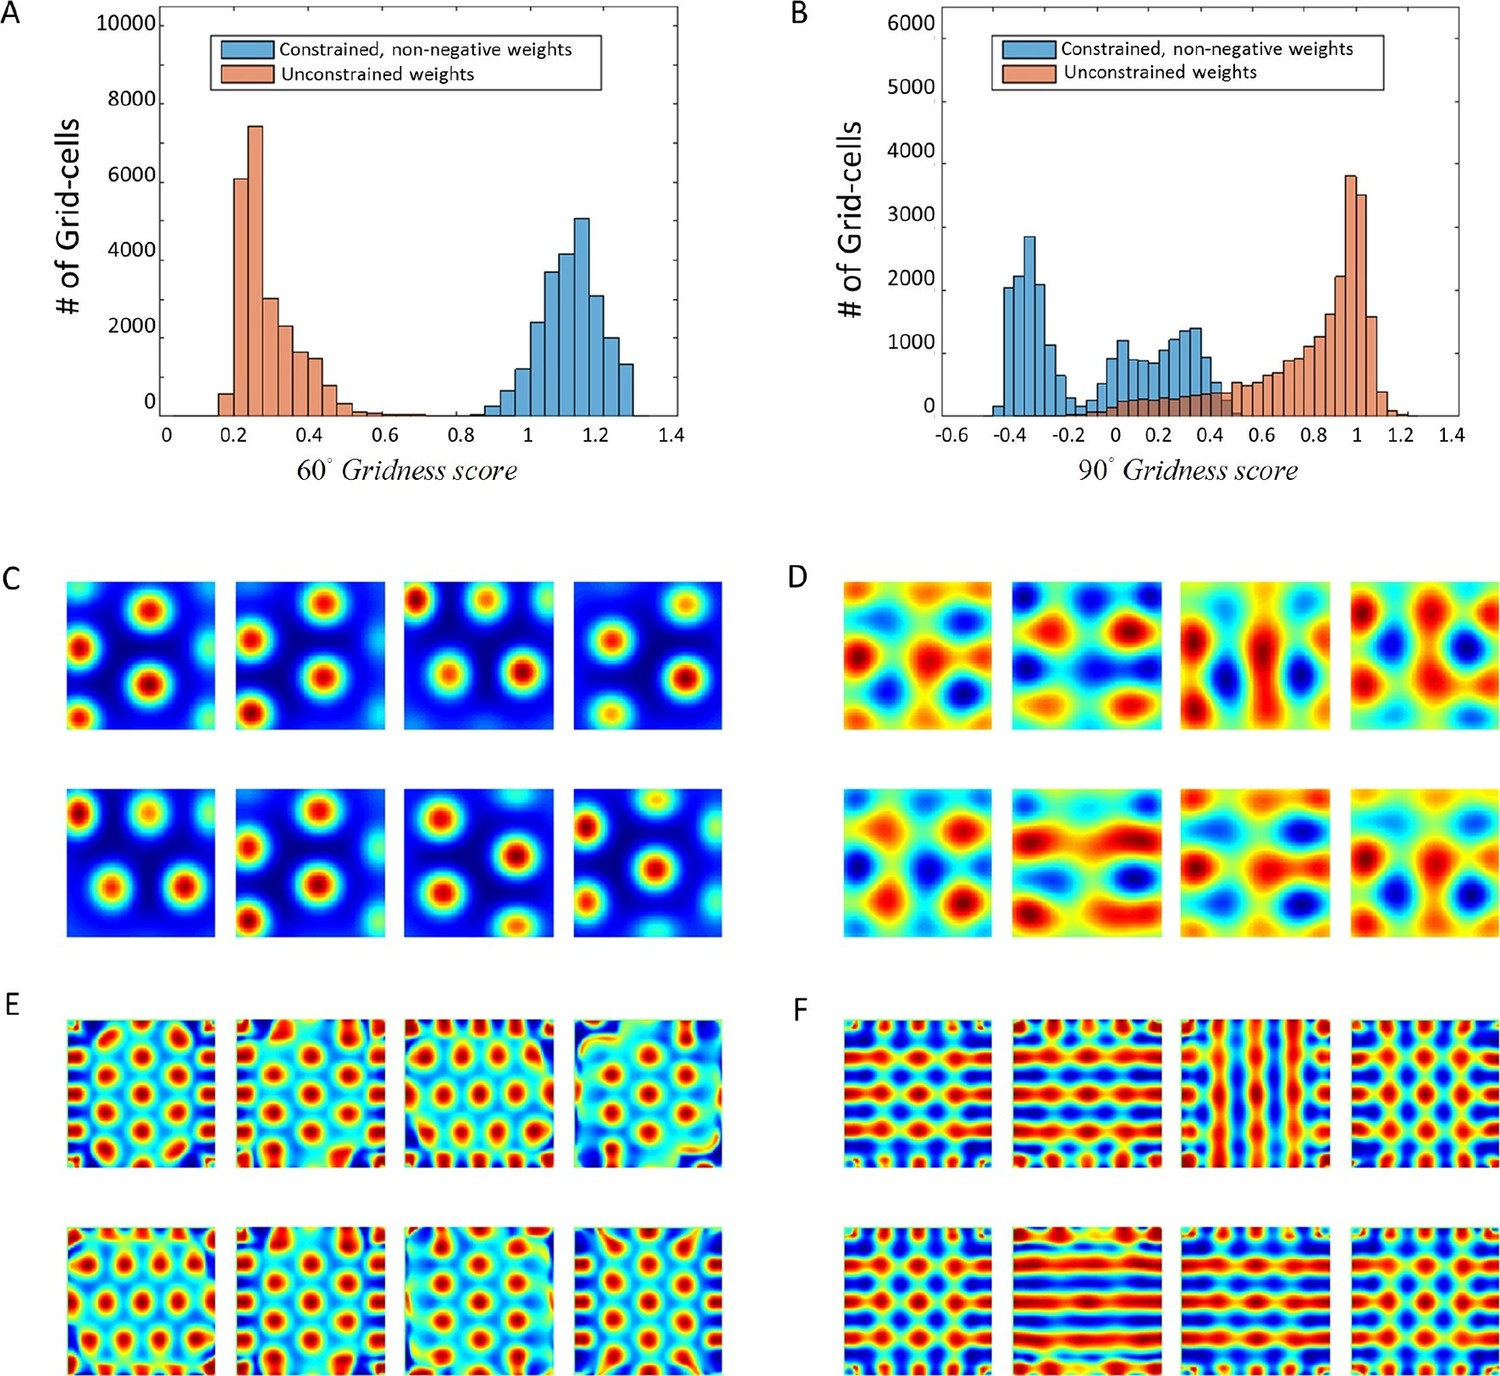

In [1]:
# @title VScode setup

#Main package dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import ratinabox as riab

#Importing files from Peter Doohan's maze codebase:

import functions.representations as mr
import functions.plotting as mp
#Note that functions and packages e.g. plt and nx will be retrievable under plotting

#Bridging networkX maze representations to RatInABox

import functions.mouse_in_a_maze as miam


C:\Users\cburns\AppData\Local\Temp\ipykernel_16000\2383632502.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Dordek et al. 2016 - rat in a box replication

Below we briefly demonstrate that weights either converge to square or hexagonal grid cell output, depending on non-negativity of weights of a feedforward layer of place cell inputs updated on Oja's (1982) learning rule (performing PCA).
[ugly, but accurate, long sentence]

For each $i$th place cell input, the weights ($W_i^t$) should be updated according to:

$$ \Delta W_i^t = \alpha^t(GC^t\cdot PC_i^t - (GC^t)^2 W_i^t) $$

where, at time $t$, $GC^t$ is the output grid cell activity, and $PC_i^t$ is the input of the $i$th place cell activity.

The activation function $f$ can be specified by rat in a box, either as a sigmoid or RELU, such that the final 'grid cell' output is a feedforward linear sum:

$$ GC^t = f(\sum_{i=1}^n W_i^t\cdot PC^t_i)$$

Thanks to Rat in a box this should be rather straight-forward.


In [2]:
# @title Rat in a box - Setup

#For reproducibility and controlled trajectory generation, we implement seeds:
PC_seed = 1
Trajectory_seed = 1

# Parameters #
n_PCs = 625
n_GCs = 10
PC_size = 0.075
PC_type = 'DOG' #'DOG for difference of gaussians
non_negativity = True #constrain weights to be non-negative?

# Default parameters # 
dt = 1/60 # matching video framerate for update rate

# hidden (secret sauce) parameters #
max_init_weight = 0.04 #
slope = 100 #

# RIAB setup #

np.random.seed(PC_seed) #this seed will determine the 

box = riab.Environment(params={"dimensionality":"2D", "scale":1}) #scaled to 1.38x1.38m as in maze environment

rat = riab.Agent(box, params={"wall_repel_distance": 0.01,
                             "wall_repel_strength": 3,
                             "dt": dt, #60Hz sampling rate (matching video framerate)
                             })
PCs = riab.PlaceCells(rat, params = {"n":n_PCs,
                                    "description":"diff_of_gaussians", #Change to check dependence
                                    "widths":PC_size, #Field size will change grid scale: S=widths*7.54+0.62, according to Dordek et al., 2016
                                    "name":"PlaceCells",
                                  # "max_fr":25, #Removing for diff of gaussians input when output is scaled.
                                  # "min_fr":0 #adding for the tanh activation function
                                    })

#for the feedforwardlayer we consider the following activation functions:
#"activation_function":   {"activation":"linear"} #DEFAULT
#                         {"activation":"tanh", "gain":100, "threshold":0} similar to atan in Dordek et al., 2016;
#                         {"activation":"sigmoid", "max_fr":20, "min_fr":0, "mid_x":1, "width":2}
#                         } #For RELU the gain helps convergence by introducing a slope. This is a hidden Dordek hyperparameter.

GCs = riab.FeedForwardLayer(rat, params={"n":n_GCs,
                                        "input_layers":[PCs],
                                        "name":"GridCells",
                                        #"activation_function":{"activation":"relu", "gain":100}
                                        }
                            )

overlay = riab.GridCells(
    rat,
    params={"n": 10,
            "color": "C2",
            "description": "three_shifted_cosines", #Solstad et al. 2006 equation 2
            "gridscale_distribution":'modules',
            "gridscale":(0.35, 0.5, 0.71)},
)

#scale the weights so they aren't "too big" to begin with; another Dordek et al., 2016 hack from out of the blue.
#rescaled = max_init_weight*(GCs.inputs['PlaceCells']['w_init'])/np.max(GCs.inputs['PlaceCells']['w_init'])
#GCs.inputs['PlaceCells']['w_init'] = rescaled

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 300x300 with 1 Axes>, <Axes: >)

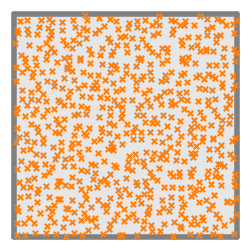

In [3]:
PCs.plot_place_cell_locations()

In [4]:
# @title Oja's rule implementation

## Function to update the weight according to Oja's learning rule
# Based off of path_integration_example demo from Rat in a box.


#Do not ask why: implementing a slope as in Dordek et al. will lead to gridness.
#Here we just make sure to remove this
if GCs.params['activation_function']['activation']!='linear':
  slope = 1

def weight_change(GCs, non_negativity):
  #To implement Oja's rule we need current GC firing rate, place cell input, and learning rate at time t.
  GC_rates = slope*GCs.firingrate #note the slope.
  PC_rates = np.tile(GCs.inputs['PlaceCells']['I'], (n_GCs,1)) #take current place cell input. Must be tiled to the number of grid cells.
  w = GCs.inputs['PlaceCells']['w'] #take current weights

  #For learning rate, Dordek et al. implement a decay.
  t = GCs.history['t'][-1]*dt #take most recent timepoint, scale it by dt so t is in increments of steps (referred to as tind in Dordek code).
  alpha = 1/(t+1e5) #as documented in Dordek et al. paper.

  #Oja's rule:
  dw = alpha*(GC_rates[:,np.newaxis]*PC_rates-(GC_rates[:,np.newaxis]**2)*w) #new-axis trick allows entry-wise multiplication across rows when there's more than one grid cell.
  #if non_negativity == True: #change the update value for all negative values in w so they become 0.
  negative_weights = np.where(w < 0)
  dw[negative_weights] = -1*w[negative_weights]
  
  return dw

In [14]:
# @title Run, rat, run!

np.random.seed(2024)

from tqdm import tqdm

rat.pos = [0.15,0.15] #intialise position inside the maze. Equivalent to maze starting position.
explore_time = 8*40*60 #time in seconds, turns into timesteps when scaled by a factor of Ag.dt

for i in (tqdm(range(int(explore_time/rat.dt)))):
    rat.update()
    PCs.update()
    GCs.update()
    GCs.inputs['PlaceCells']['w'] += weight_change(GCs, non_negativity) #update the weights
    if i == (explore_time/2)/rat.dt:
        half_time_w = GCs.inputs['PlaceCells']['w'].copy()

100%|██████████| 1152000/1152000 [21:45<00:00, 882.32it/s] 


In [15]:
#Quick check that 'some' learning has happened
print(np.max(GCs.inputs['PlaceCells']['w_init']))
print(np.max(GCs.inputs['PlaceCells']['w']))
print(np.min(GCs.inputs['PlaceCells']['w_init']))
print(np.min(GCs.inputs['PlaceCells']['w']))

0.14205078118534356
0.028471779861448776
-0.16265186339101254
-1.1494926356649106e-05


## Plotting

First, we plot the weights onto the place cell centres to see whether any pattern shows up.

However, we almost definitely want to demonstrate that these patterns show up in spike plots.

In [ ]:
animation = rat.animate_trajectory(t_start=0, t_end=30, alpha=0.2, color='changing') #animate the rat if you want (takes 3 minutes)


In [ ]:
riab.figure_directory = "/content/drive/MyDrive/Colab Notebooks/Burns/figures"
riab.utils.save_figure(animation, 'Test_save.gif')



Animation saved to /content/drive/MyDrive/Colab Notebooks/Burns/figures/21_02_24/Test_save.gif_1403.mp4


'/content/drive/MyDrive/Colab Notebooks/Burns/figures/21_02_24/Test_save.gif_1403'

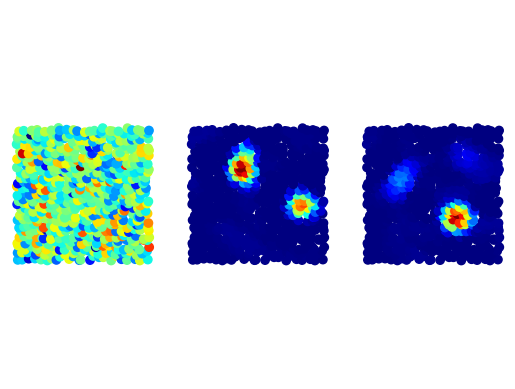

In [16]:
#Plotting weights back onto place cell space.

cell_index = 1 #Index out a grid cell and plot before and after weights

fig, axs = plt.subplots()
axs.axis('off')

ax1 = fig.add_subplot(1,3,1)
ax1.set_aspect('equal')
ax1.axis('off')

init_weights = GCs.inputs['PlaceCells']['w_init'][cell_index]
ax1.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=init_weights,
            cmap = "jet")

ax2 = fig.add_subplot(1,3,2)
ax2.set_aspect('equal')
ax2.axis('off')

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=half_time_w[cell_index],
            cmap = "jet")

ax2 = fig.add_subplot(1,3,3)
ax2.set_aspect('equal')
ax2.axis('off')

weights = GCs.inputs['PlaceCells']['w'][cell_index]

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=weights,
            cmap = "jet")


(<Figure size 3000x300 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

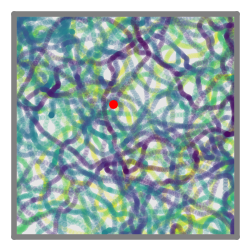

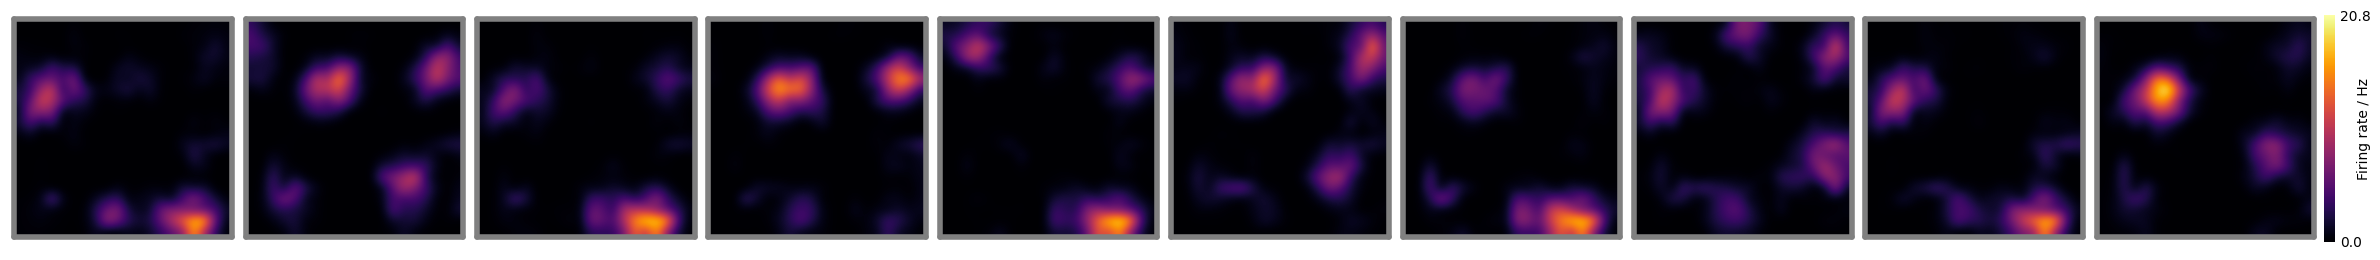

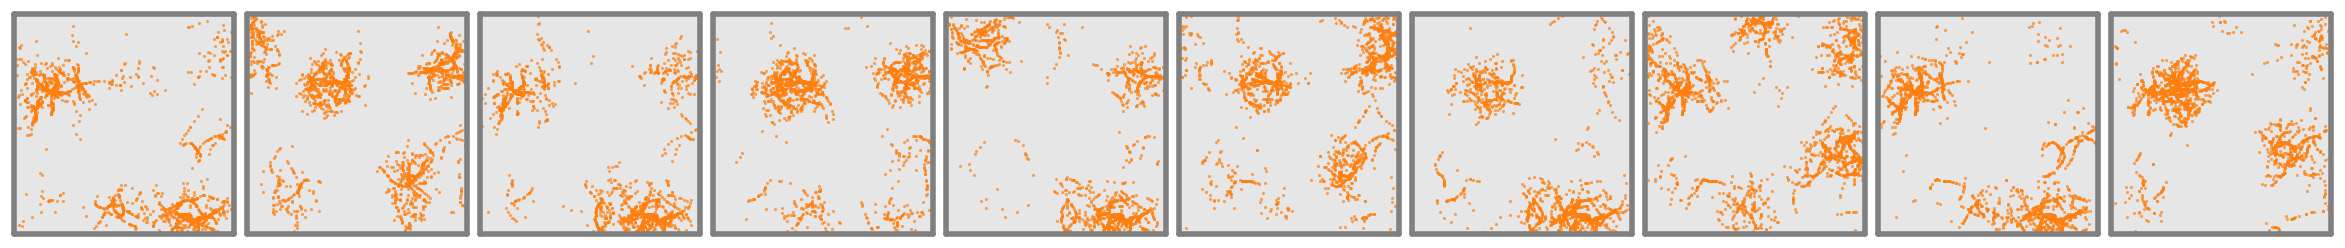

In [8]:
#First 20 minutes of exploration

plot_end_time = 20*60

rat.plot_trajectory(t_start=0, t_end =plot_end_time, alpha=0.2, color='changing')
GCs.plot_rate_map(method='history',  t_start = 0, t_end = plot_end_time )
GCs.plot_rate_map(method='neither', spikes = True, t_start = 0, t_end = plot_end_time)


(<Figure size 3000x300 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

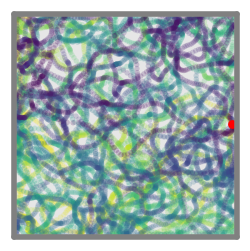

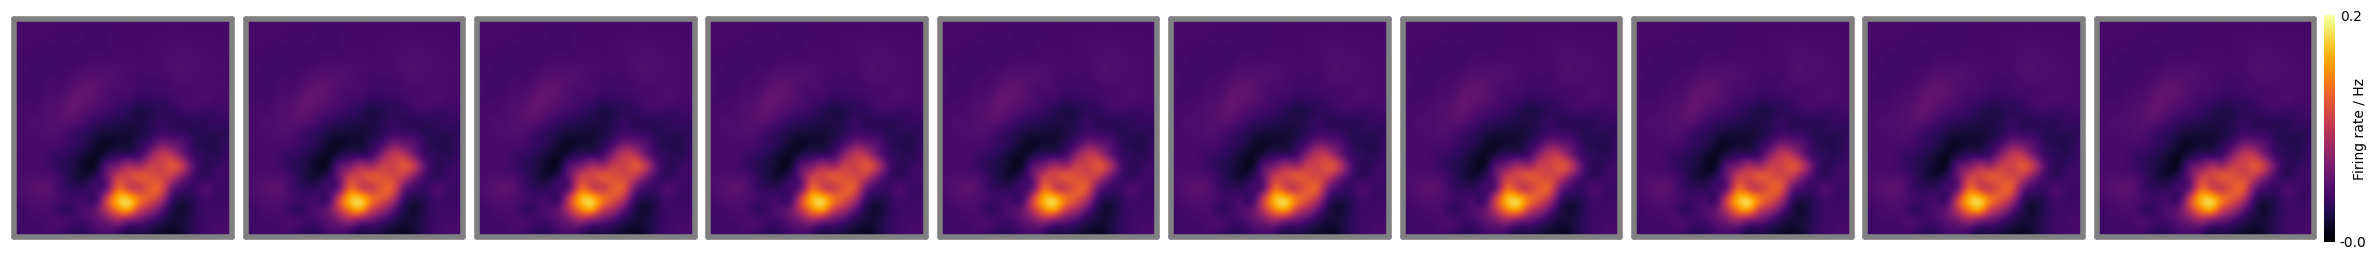

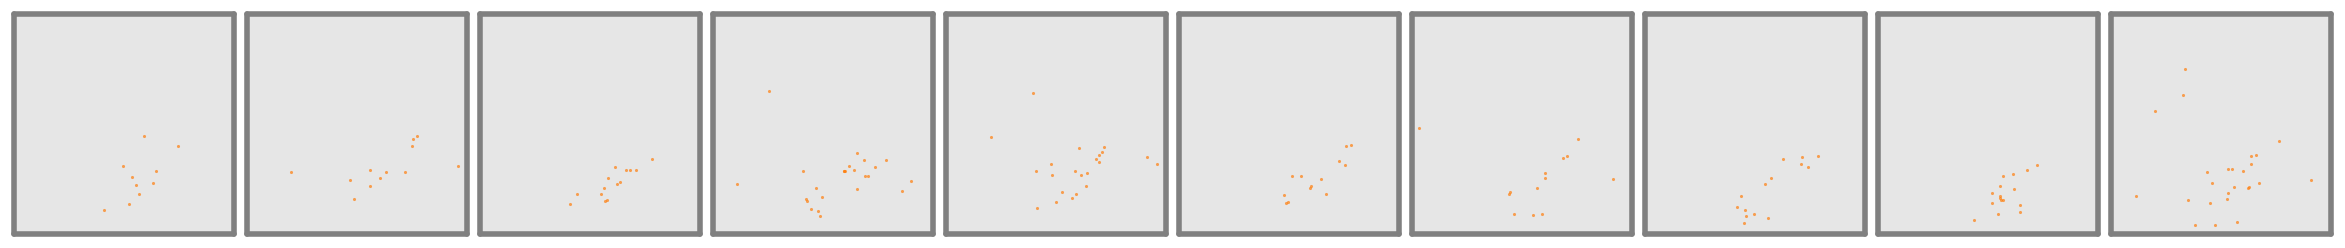

In [17]:
#Last 20 minutes of exploration

plot_start_time = rat.t-20*60

rat.plot_trajectory(t_start=plot_start_time, color="changing", alpha=0.2)
GCs.plot_rate_map(method='history', t_start = plot_start_time)
GCs.plot_rate_map(method='neither', spikes = True, t_start = plot_start_time)

# Dordek et al., 2016 - mouse in a maze implementation

We've written a script to turn a maze into a rat in a box environment.

'geodesic' wall geometry only supported for enivironments with 1 additional wall (4 bounding walls + 1 additional). Sorry. Using 'line_of_sight' instead.


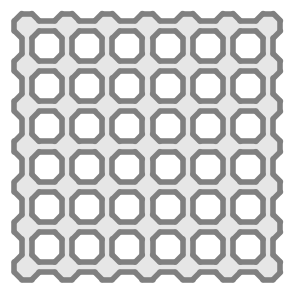

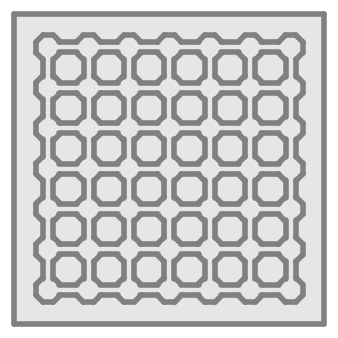

In [7]:
maze_idx = 'FC' #can be FC, 1, 2, or HP
maze = mr.get_simple_maze(maze_idx)
maze_fine = mr.get_extended_simple_maze(maze) #we need the finer-scale for plotting heatmaps in either case.

env = miam.get_maze_env(maze)
env.plot_environment()

env_walls = miam.get_maze_env_walls(maze)
env_walls.plot_environment()

mouse = riab.Agent(env, params={"wall_repel_distance": 0.01,
                             "wall_repel_strength": 3,
                             "dt": 1/60, #60Hz sampling rate (matching video framerate)
                             })
PCs = riab.PlaceCells(mouse, params = {"n":n_PCs,
                                    "description":"diff_of_gaussians", #Change to check dependence
                                    "widths":0.075, #Field size will change grid scale: S=widths*7.54+0.62, according to Dordek et al., 2016
                                    "name":"PlaceCells",
                                  # "max_fr":25, #Removing for diff of gaussians input when output is scaled.
                                  # "min_fr":0 #adding for the tanh activation function
                                    })

#for the feedforwardlayer we consider the following activation functions:
#"activation_function":   {"activation":"linear"} #DEFAULT
#                         {"activation":"tanh", "gain":100, "threshold":0} similar to atan in Dordek et al., 2016;
#                         {"activation":"sigmoid", "max_fr":20, "min_fr":0, "mid_x":1, "width":2}
#                         } #For RELU the gain helps convergence by introducing a slope. This is a hidden Dordek hyperparameter.

GCs = riab.FeedForwardLayer(mouse, params={"n":n_GCs,
                                        "input_layers":[PCs],
                                        "name":"GridCells",
                                        "activation_function":{"activation":"relu", "gain":100}
                                        }
                            )

In [8]:
## generate trajectory ##

np.random.seed(Trajectory_seed)

from tqdm import tqdm

mouse.pos = [0.15,0.15] #intialise position inside the maze.
explore_time = 8*40*60 #time in seconds

for i in (tqdm(range(int(explore_time/mouse.dt)))): 
    mouse.update()
    PCs.update()
    #GCs.update()
    #GCs.inputs['PlaceCells']['w'] += weight_change(GCs, non_negativity) #update the weights
    #if i == (explore_time/2)/rat.dt:
    #  half_time_w = GCs.inputs['PlaceCells']['w'].copy()


## save trajectory ##

#it'll have a crap name, because it needs to know whether 
#   1) what maze it is
#   2) min
#   3) n_PCs
#   4) PC_size
#   5) PC_seed
#   6) TJ_seed

trajectory_data = pd.DataFrame(mouse.history).merge(pd.DataFrame(PCs.history))

trajectory_directory = 'C:/Users/cburns/Documents/Research/maze_grid_cells/data/trajectories'
file_name = trajectory_directory + '/maze_'+str(maze_idx) +'_'+ str(explore_time/60) + '_min_' + str(n_PCs)+str(PC_type)+'_PCs_size_'+str(PC_size)+'_seed_'+str(PC_seed)+'_TJ_seed_'+str(Trajectory_seed) +'.json'

trajectory_data.to_json(file_name, index=False)

100%|██████████| 1152000/1152000 [8:42:46<00:00, 36.73it/s]  


In [9]:
## load trajectory ##

imported_data = pd.read_json(file_name)

In [10]:
#note, 1,152,000 iterations took 10 minutes
for i in (tqdm(range(int(explore_time/mouse.dt)))):
    mouse.t = imported_data['t'][i]
    mouse.pos = imported_data['pos'][i]
    PCs.firingrate = imported_data['firingrate'][i]
    GCs.update()
    GCs.inputs['PlaceCells']['w'] += weight_change(GCs, non_negativity) #update the weights
    if i == (explore_time/2)/rat.dt:
        half_time_w = GCs.inputs['PlaceCells']['w'].copy()

  0%|          | 0/1152000 [00:00<?, ?it/s]

100%|██████████| 1152000/1152000 [11:01<00:00, 1740.87it/s]


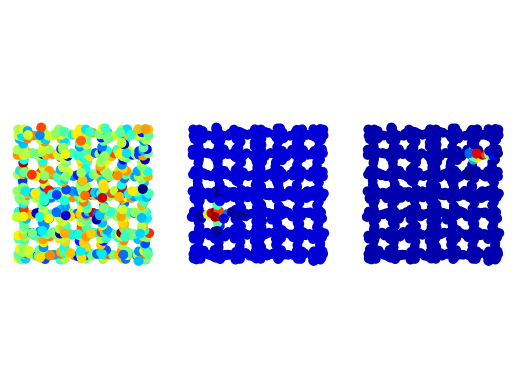

In [21]:
#Plotting weights back onto place cell space.

cell_index = 4 #Index out a grid cell and plot before and after weights

fig, axs = plt.subplots()
axs.axis('off')

ax1 = fig.add_subplot(1,3,1)
ax1.set_aspect('equal')
ax1.axis('off')

init_weights = GCs.inputs['PlaceCells']['w_init'][cell_index]
ax1.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=init_weights,
            cmap = "jet")

ax2 = fig.add_subplot(1,3,2)
ax2.set_aspect('equal')
ax2.axis('off')

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=half_time_w[cell_index],
            cmap = "jet")

ax2 = fig.add_subplot(1,3,3)
ax2.set_aspect('equal')
ax2.axis('off')

weights = GCs.inputs['PlaceCells']['w'][cell_index]

ax2.scatter(x=PCs.place_cell_centres[:,0],
            y=PCs.place_cell_centres[:,1],
            c=weights,
            cmap = "jet")


In [25]:
PCs.plot_rate_map(chosen_neuron="1",method='neither', spikes = True, t_start = 0, t_end = plot_end_time)

(<Figure size 3570.68x357.068 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

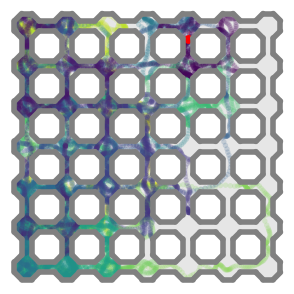

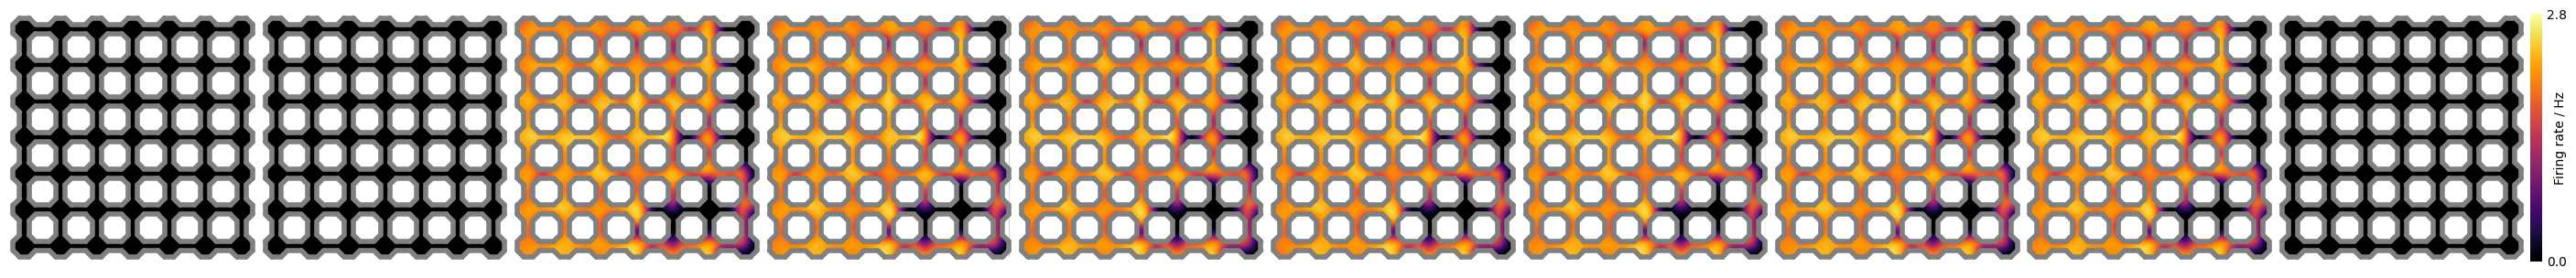

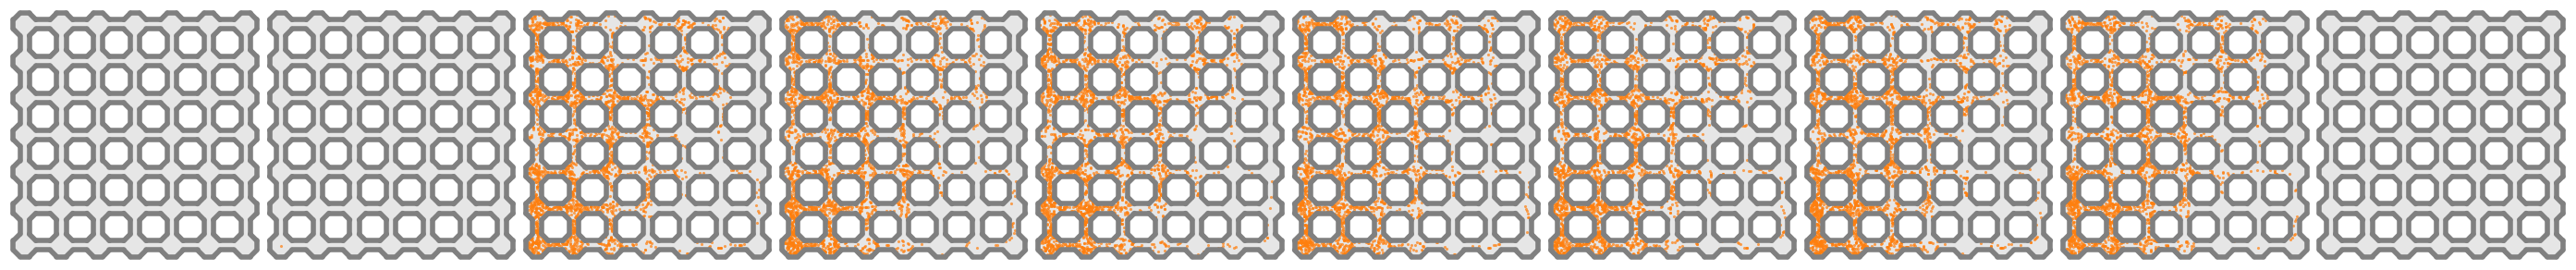

In [23]:
#First 20 minutes of exploration

plot_end_time = 20*60

mouse.plot_trajectory(t_start=0, t_end =plot_end_time, alpha=0.2, color='changing')
GCs.plot_rate_map(method='history',  t_start = 0, t_end = plot_end_time )
GCs.plot_rate_map(method='neither', spikes = True, t_start = 0, t_end = plot_end_time)


## Plotting onto Peter's heatmaps

First with centre firing rate

In [27]:
#points = sampling.sample_maze_points(maze, 1000)

centres = mp.nx.get_node_attributes(maze_fine,'position').values()

firingRate = GCs.get_state(evaluate_at='None', pos=list(centres))

label = mp.nx.get_node_attributes(maze_fine,'label').values()

values = mp.pd.Series(data=firingRate[5], index=label)
values.index.name='maze_position' #Further required for the plot function to work

fig, ax = mp.plt.subplots()
ax.axis('off')

mp.plot_simple_heatmap(maze, values, ax)

#test = env.sample_positions(n=1000)
#x,y = zip(*test)
#mp.plt.scatter(x, y)

AttributeError: 'list' object has no attribute 'shape'

We also want to take the average firing rate within each tower or bridge.
I wonder if Peter has code for that.

He does. The trick is to map the firing rate at a set of coordinates to the nearest neighbour (node or edge centre).

In [37]:
Agent_data = pd.DataFrame(Ag.history)
Grid_cell_data = pd.DataFrame(GCs.history)

data = pd.merge(Agent_data,Grid_cell_data) #merges by shared columns (t)

#Nearest neighbour from https://stackoverflow.com/questions/57129448/find-distance-to-nearest-neighbor-in-2d-array

from scipy.spatial.distance import cdist

def nearest_neighbour_pos(agent_positions,maze_positions):
  #INPUT:
    dists = cdist(agent_positions,maze_positions)
    nn_dist = np.sort(dists)[0]
    return nn_dist



NameError: name 'Ag' is not defined

In [ ]:
#Using Peter's functions:

from scipy.spatial import KDTree

def get_position2simple_coord_dict(simple_maze):
    """Get a dictionary mapping maze node/edge positions to maze node/edge coordinates"""
    position2simple_node = {tuple(position):node for node, position in simple_maze.nodes(data='position')}
    position2simple_edge={tuple(position):(node1, node2) for node1,node2,position in simple_maze.edges(data='position')}
    position2simple_coord = position2simple_node.copy(); position2simple_coord.update(position2simple_edge)
    return position2simple_coord

def get_nearest_simple_coord(centroid_positions, maze):
    """Get the nearest maze node for each position in the centroid_positions array."""
    position2maze_coord = get_position2simple_coord_dict(maze)
    coord_positions = list(position2maze_coord.keys())
    kd_tree = KDTree(coord_positions) #Create a KDTree from the maze coord positions
    _, nearest_node_indices = kd_tree.query(centroid_positions) # Query the KDTree to get the nearest maze node for each position
    nearest_nodes = [position2maze_coord[tuple(coord_positions[i])] for i in nearest_node_indices]
    return nearest_nodes


agent_positions = list(Agent_data.pos)

nearest_pos = get_nearest_simple_coord(agent_positions, maze)

data = data.assign(nn_maze = nearest_pos)

#OBS: may just ask Peter for the standard data format. That'll be faster.

# Playground

Just mucking about


In [ ]:
DF = get_open_field_heatmaps.get_simulated_navigation_rates_df(1, session_length=30, moving_threshold=0.1)

